In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import MoonsDataset
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.losses import BinaryDiscLoss

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = MoonsDataset("../data/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

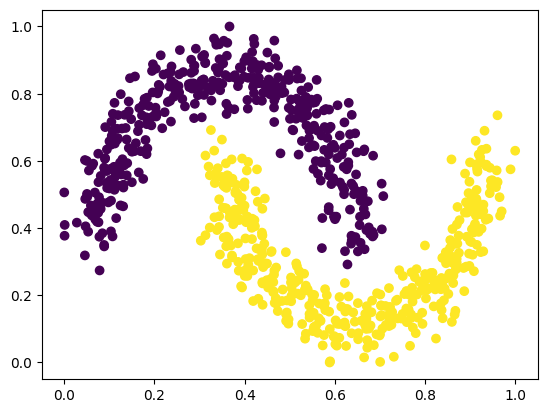

In [4]:
for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

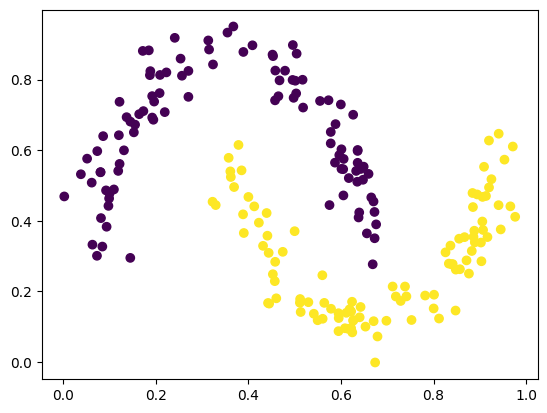

In [5]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [8]:
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1
)
disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

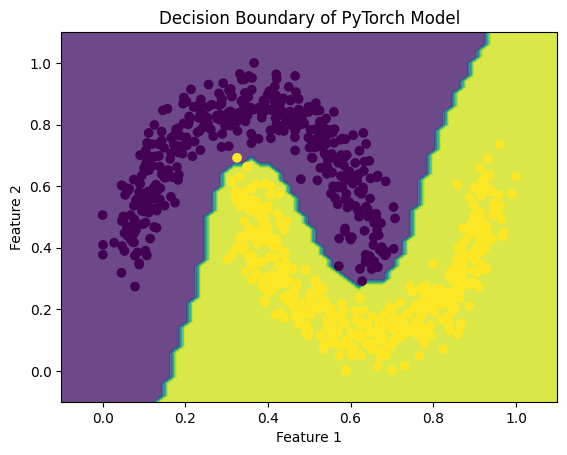

In [9]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the grid points
disc_model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = disc_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model")

for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
disc_model.fit(train_dataloader, test_dataloader, epochs=1000, lr=0.01)

In [ ]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1], hidden_features=8, context_features=1
)
gen_train_dataloader = dataset.train_dataloader(
    batch_size=1024, shuffle=True, noise_lvl=0.03
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=1000)

In [ ]:
cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
median_log_prob = torch.median(gen_model.predict_log_prob(cf_dataloader))
print(median_log_prob)
deltas, X_orig, y_orig, y_target, logs = cf.search_batch(
    cf_dataloader, alpha=100, median_log_prob=median_log_prob, epochs=4000
)

In [ ]:
logs["cf_search/loss_disc"][-10:]

In [ ]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

In [ ]:
X_cf = X_orig + deltas

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

In [ ]:
X_cf